# PNEUMONIA DETECTION WITH RESNET50

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# seed_value = 42
# random.seed(seed_value)
# np.random.seed(seed_value)
# tf.random.set_seed(seed_value)

In [2]:
print("Tensorflow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.17.0
Num GPUs Available: 0


## Data Preprocessing

### Data Visualization

In [3]:
train_dir = '../chest-xray-pneumonia/Data_blance/Train'
test_dir = '../chest-xray-pneumonia/Data_blance/Test'
val_dir = '../chest-xray-pneumonia/Data_blance/Val'

print("Train set:\n========================================")
train_normal = len(os.listdir(os.path.join(train_dir, 'Normal')))
train_bacteria = len(os.listdir(os.path.join(train_dir, 'bacteria')))
train_virus = len(os.listdir(os.path.join(train_dir, 'virus')))
print(f"NORMAL={train_normal}")
print(f"BACTERIA={train_bacteria}")
print(f"VIRUS={train_virus}")

print("\nTest set:\n========================================")
test_normal = len(os.listdir(os.path.join(test_dir, 'Normal')))
test_bacteria = len(os.listdir(os.path.join(test_dir, 'bacteria')))
test_virus = len(os.listdir(os.path.join(test_dir, 'virus')))
print(f"NORMAL={test_normal}")
print(f"BACTERIA={test_bacteria}")
print(f"VIRUS={test_virus}")

print("\nValidation set:\n========================================")
val_normal = len(os.listdir(os.path.join(val_dir, 'Normal')))
val_bacteria = len(os.listdir(os.path.join(val_dir, 'bacteria')))
val_virus = len(os.listdir(os.path.join(val_dir, 'virus')))
print(f"NORMAL={val_normal}")
print(f"BACTERIA={val_bacteria}")
print(f"VIRUS={val_virus}")

Train set:
NORMAL=1300
BACTERIA=1300
VIRUS=1300

Test set:
NORMAL=100
BACTERIA=100
VIRUS=100

Validation set:
NORMAL=93
BACTERIA=93
VIRUS=93


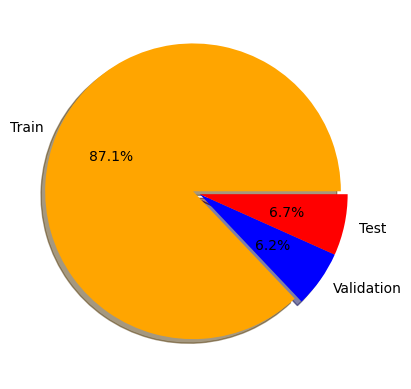

In [4]:
train_samples = train_normal + train_bacteria + train_virus
val_samples = val_normal + val_bacteria + val_virus
test_samples = test_normal + test_bacteria + test_virus

plt.pie(
    [train_samples, val_samples, test_samples],
    labels=['Train', 'Validation', 'Test'],
    autopct='%.1f%%',
    colors=['orange', 'blue', 'red'],
    explode=[0.05, 0, 0],
    shadow=True
)
plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
batch_size = 32
channels = 3   # 3 channels for color images

train_datagen = ImageDataGenerator(
    rescale = 1./255.0,
    zca_whitening = False,
    horizontal_flip = True,
    vertical_flip = False,
    shear_range = 0.2,
    zoom_range = 0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255.0)

train_set = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
)

test_set = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
)

val_set = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
)

Found 3900 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 279 images belonging to 3 classes.


In [6]:
print(train_set.class_indices)
print(test_set.class_indices)
print(val_set.class_indices)

{'Normal': 0, 'bacteria': 1, 'virus': 2}
{'Normal': 0, 'bacteria': 1, 'virus': 2}
{'Normal': 0, 'bacteria': 1, 'virus': 2}


## Build Model

### Compute Class Weights for Imbalanced Dataset

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight

# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_set.classes),
#     y=train_set.classes,
# )
# class_weights_dict = dict(enumerate(class_weights))
# print(class_weights_dict)

### Create Model

In [7]:
from tensorflow.keras.applications import ResNet50

# Load ResNet model pre-trained on ImageNet, without the fully connected layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, channels), pooling='max')

# Freeze the layers of ResNet
for layer in resnet_base.layers:
    layer.trainable = False

resnet_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
num_classes = len(train_set.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 3


In [9]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Define input layer
inputs = Input(shape=(img_size, img_size, channels))

# Add ResNet base
x = resnet_base(inputs)

# Add custom layers
x = Dense(2048, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create model
model = Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,571,651 (116.62 MB)

 Trainable params: 6,983,939 (26.64 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Train Model

In [11]:
def compile_model(model):
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    # Compile the model
    model.compile(optimizer=opt, loss=loss, metrics=metrics)

compile_model(model)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

os.makedirs('saved_models', exist_ok=True)
checkpoint_filepath = "saved_models/resnet_ckpt.weights.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose = 1)
hist = model.fit(
  x=train_set, 
  epochs=30, 
  validation_data=val_set,
  callbacks=[checkpoint_callback, early_stopping_callback]
  # class_weight=class_weights_dict,
)

Epoch 1/30


c:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3543 - loss: 1.4255 - precision: 0.3528 - recall: 0.1488
Epoch 1: val_loss improved from inf to 1.03223, saving model to saved_models/resnet_ckpt.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - accuracy: 0.3544 - loss: 1.4236 - precision: 0.3529 - recall: 0.1481 - val_accuracy: 0.5376 - val_loss: 1.0322 - val_precision: 1.0000 - val_recall: 0.0358
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4813 - loss: 1.0089 - precision: 0.5557 - recall: 0.1689
Epoch 2: val_loss improved from 1.03223 to 0.83551, saving model to saved_models/resnet_ckpt.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.4815 - loss: 1.0085 - precision: 0.5561 - recall: 0.1697 - val_accuracy: 0.5556 - val_loss: 0.8355 - val_precision: 0.5784 - val_recall: 0.3835
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5522 - loss: 0.8691 - precision: 0.6125 - recall: 0.4144
Epoch 3: val_loss improved from 0.83551 t

In [13]:
print(hist.history.keys())
# print(hist.history)

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])


In [14]:
scores_train = model.evaluate(train_set)

122/122 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.6808 - loss: 0.6776 - precision: 0.7116 - recall: 0.5987


In [15]:
scores_test = model.evaluate(test_set)

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8098 - loss: 0.4831 - precision: 0.8609 - recall: 0.7674


In [16]:
scores_val = model.evaluate(val_set)

9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8112 - loss: 0.4878 - precision: 0.8377 - recall: 0.7704


In [17]:
# Print evaluation scores
print("Train Loss:", scores_train[0])
print("Train Accuracy:", scores_train[1])
print("Test Loss:", scores_test[0])
print("Test Accuracy:", scores_test[1])
print("Validation Loss:", scores_val[0])
print("Validation Accuracy:", scores_val[1])

Train Loss: 0.7061388492584229
Train Accuracy: 0.654358983039856
Test Loss: 0.6534873247146606
Test Accuracy: 0.6666666865348816
Validation Loss: 0.670813798904419
Validation Accuracy: 0.6559139490127563


## Plot Loss & Accuracy

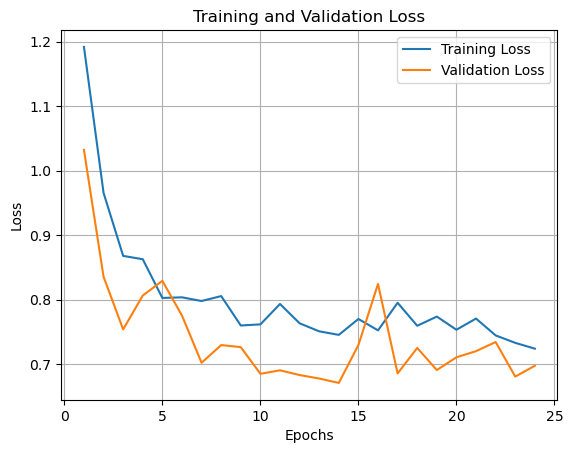

In [18]:
# Extract the training and validation loss values from the history object
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plot the loss graph
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

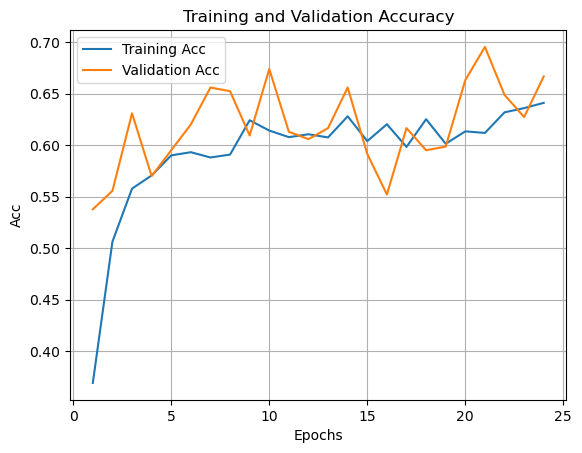

In [19]:
# Extract the training and validation accuracy values from the history object
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_accuracy) + 1)

# Plot the accuracy graph
plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate Model

In [23]:
y_pred_probs = model.predict(test_set)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_set.classes

10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


In [24]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_true, y_pred))

report = classification_report(y_true, y_pred, target_names=val_set.class_indices)
print(report)

[[94  1  5]
 [ 6 67 27]
 [16 45 39]]
              precision    recall  f1-score   support

      Normal       0.81      0.94      0.87       100
    bacteria       0.59      0.67      0.63       100
       virus       0.55      0.39      0.46       100

    accuracy                           0.67       300
   macro avg       0.65      0.67      0.65       300
weighted avg       0.65      0.67      0.65       300



## Save Model

In [22]:
# Save model as JSON
model_json = model.to_json()
with open("./saved_models/resnet50.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./saved_models/resnet50.weights.h5")
print("Saved model to disk")

Saved model to disk
